# Configure Aggregate Module Params

This notebook should be used as a test for ensuring correct aggregate parameters before aggregate processing.
Cells marked with `SET PARAMETERS` contain crucial variables that need to be set according to your specific experimental setup and data organization.
Please review and modify these variables as needed before proceeding with the analysis.

## SET PARAMETERS

### Fixed parameters for merge processing

- `CONFIG_FILE_PATH`: Path to a Brieflow config file used during processing. Absolute or relative to where workflows are run from.

In [1]:
CONFIG_FILE_PATH = "config/config.yml"

In [2]:
from pathlib import Path

import yaml
import pandas as pd
import matplotlib.pyplot as plt

from lib.aggregate.load_format_data import (
    load_hdf_subset,
    clean_cell_data,
    add_filenames,
)
from lib.aggregate.feature_processing import (
    feature_transform,
    suggest_parameters,
    grouped_standardization,
    collapse_to_sgrna,
    collapse_to_gene,
)
from lib.aggregate.cell_classification import (
    plot_mitotic_distribution_hist,
    plot_mitotic_distribution_scatter,
    split_mitotic_simple,
)
from lib.aggregate.montage_utils import create_mitotic_cell_montage

## SET PARAMETERS

### Loading subset of data

- `POPULATION_FEATURE`: The column name that identifies your perturbation groups (e.g., 'gene_symbol_0' for CRISPR screens, 'treatment' for drug screens)

In [3]:
POPULATION_FEATURE = "gene_symbol_0"

In [4]:
# load config file and determine root path
with open(CONFIG_FILE_PATH, "r") as config_file:
    config = yaml.safe_load(config_file)
ROOT_FP = Path(config["all"]["root_fp"])

# Load subset of data
# Takes ~1 minute
merge_final_fp = ROOT_FP / "merge_process" / "hdfs" / "merge_final.hdf5"
raw_df = load_hdf_subset(
    merge_final_fp, n_rows=50000, population_feature=POPULATION_FEATURE
)

# Remove unassigned cells
clean_df = clean_cell_data(raw_df, POPULATION_FEATURE, filter_single_gene=False)
# pd.Series(raw_df.columns).to_csv('aggregate_4/column_names.csv', index=False)
print(f"Loaded {len(raw_df)} cells with {len(raw_df.columns)} features")

Reading first 50,000 rows from analysis_root/merge_process/hdfs/merge_final.hdf5
Unique populations: 4623
well
A2    25154
A1    24846
Name: count, dtype: int64
Found 23022 cells with assigned perturbations
Loaded 50000 cells with 1683 features


## SET PARAMETERS

### Apply feature transformations

- `TRANFORMATIONS_FP`: CSV file containing feature transformation specifications. Each row defines a feature pattern and its transformation (e.g., 'log(feature)', 'log(feature-1)'), and should have a feature and transformation column

In [5]:
TRANFORMATIONS_FP = "config/transformations.tsv"

In [6]:
# load lower case version of channels
channels = [channel.lower() for channel in config["phenotype_process"]["channel_names"]]

# load transformations
transformations = pd.read_csv(TRANFORMATIONS_FP, sep="\t")

# perform feature transformation
transformed_df = feature_transform(clean_df, transformations, channels)
transformed_df

/lab/barcheese01/rkern/miniconda3/envs/brieflow_configuration/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


,well,tile,cell_0,i_0,j_0,site,cell_1,i_1,j_1,distance,...,cell_number_neighbors_1,cell_percent_touching_1,cell_first_neighbor_distance,cell_second_neighbor_distance,cell_angle_between_neighbors,cytoplasm_number_neighbors_1,cytoplasm_percent_touching_1,cytoplasm_first_neighbor_distance,cytoplasm_second_neighbor_distance,cytoplasm_angle_between_neighbors
9,A2,905,567,1482.224982,1481.369056,217,1968,671.092784,101.958763,0.149559,...,0,0.000000,59.020638,59.446369,157.601917,0.0,0.000000,60.919552,62.456065,150.540954
11,A1,1502,499,1480.591457,1477.269347,354,269,100.472868,99.922481,0.145653,...,0,0.000000,50.862138,74.697479,151.299725,0.0,0.000000,52.537544,71.361624,165.587553
15,A2,1368,522,1480.857229,1476.934664,325,284,100.825243,100.436893,0.180161,...,0,0.000000,90.256086,96.366612,43.202061,0.0,0.000000,94.688817,101.806778,37.325935
19,A2,832,579,1483.300457,1481.761594,218,293,100.020619,101.144330,0.395906,...,1,0.285714,56.619206,67.570229,102.565383,1.0,0.177106,62.803962,66.980804,99.027314
23,A1,418,499,1476.278287,1478.299694,109,286,99.273810,98.892857,0.075175,...,0,0.000000,48.263332,66.138147,165.590938,0.0,0.000000,49.133680,71.571187,174.283650
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49990,A1,838,545,1598.246973,1327.407385,215,344,129.131313,61.484848,0.278980,...,0,0.000000,65.108539,91.830725,138.082263,0.0,0.000000,67.253756,92.008217,136.012198
49992,A1,1438,436,1412.378292,1660.818882,351,171,83.470588,146.098039,0.210144,...,0,0.000000,75.807628,97.823042,59.732586,0.0,0.000000,74.377920,94.409159,101.775957
49996,A2,361,344,1302.862956,1556.767205,82,1489,626.941748,120.485437,0.187461,...,0,0.000000,85.521857,103.909836,63.600237,0.0,0.000000,88.696553,101.486088,64.907789
49998,A2,1495,611,1619.156885,1613.819977,357,392,135.649123,705.315789,0.192781,...,1,0.160839,49.715872,52.119155,174.042063,1.0,0.090551,53.628804,57.179754,162.854502


## SET PARAMETERS

### Standardize features

- `CONTROL_PREFIX`: Prefix identifying control populations.
- `GROUP_COLUMNS`: Columns defining experimental groups (e.g., `['well']` for per-well standardization).
- `INDEX_COLUMNS`: Columns uniquely identifying cells (e.g., `['tile', 'cell_0']`).
- `CAT_COLUMNS`: Categorical columns to preserve.
- `FEATURE_START`: First column containing measured features.

We provide a useful function for suggesting these parameters, `suggest_parameters`.

In [7]:
suggest_parameters(clean_df, POPULATION_FEATURE)

Suggested Parameters:
--------------------------------------------------

Potential control prefixes found:
  - 'TNNT2'
  - 'nontargeting'
  - 'CNTROB'
  - 'INTS10'
  - 'CCNT1'
  - 'INTS5'
  - 'NTF4'
  - 'INTS13'
  - 'TENT4B'
  - 'B3GNT3'
  - 'NT5C3B'
  - 'RINT1'
  - 'PCNT'
  - 'INTS6'
  - 'FNTB'
  - 'INTS9'
  - 'SPINT1'
  - 'NT5C'
  - 'INTS8'
  - 'ARNTL2'
  - 'INTS12'
  - 'ZWINT'
  - 'NTF3'
  - 'TRNT1'
  - 'INTS2'
  - 'INTS3'
  - 'MNT'
  - 'BPNT1'
  - 'FNTA'
  - 'B3GNT4'
  - 'ANTXRL'
  - 'INTS7'
  - 'INTS11'
  - 'TNNT1'
  - 'KNTC1'
  - 'DNTTIP2'
  - 'B3GNT2'
  - 'CNTNAP1'

First few feature columns detected:
  - 'nucleus_dapi_mean'
  - 'nucleus_coxiv_mean'
  - 'nucleus_cenpa_mean'
  - 'nucleus_wga_mean'
  - 'nucleus_dapi_std'

Metadata columns detected:
  - Categorical: well, sgRNA_0, gene_symbol_0, mapped_single_gene


In [8]:
CONTROL_PREFIX = "nontargeting"
GROUP_COLUMNS = ["well"]
INDEX_COLUMNS = ["tile", "cell_0"]
CAT_COLUMNS = ["gene_symbol_0", "sgRNA_0"]
FEATURE_START = "nucleus_dapi_mean"

In [9]:
# Identify features to standardize (all columns after mapped_single_gene)
feature_start_idx = transformed_df.columns.get_loc(FEATURE_START)
target_features = transformed_df.columns[feature_start_idx:].tolist()
# Standardize the data
standardized_df = grouped_standardization(
    transformed_df,
    population_feature=POPULATION_FEATURE,
    control_prefix=CONTROL_PREFIX,
    group_columns=GROUP_COLUMNS,
    index_columns=INDEX_COLUMNS,
    cat_columns=CAT_COLUMNS,
    target_features=target_features,
    drop_features=False,
)

# add phenotype image filenames for each well/tile
standardized_df = add_filenames(standardized_df, ROOT_FP)

standardized_df

,well,tile,cell_0,i_0,j_0,site,cell_1,i_1,j_1,distance,...,cell_percent_touching_1,cell_first_neighbor_distance,cell_second_neighbor_distance,cell_angle_between_neighbors,cytoplasm_number_neighbors_1,cytoplasm_percent_touching_1,cytoplasm_first_neighbor_distance,cytoplasm_second_neighbor_distance,cytoplasm_angle_between_neighbors,image_path
0,A2,905,567,1482.224982,1481.369056,217,1968,671.092784,101.958763,0.149559,...,NaN,0.123011,-0.747438,0.793857,NaN,NaN,0.198123,-0.535340,0.657262,analysis_root/preprocess/images/phenotype/WA2_...
1,A1,1502,499,1480.591457,1477.269347,354,269,100.472868,99.922481,0.145653,...,NaN,-0.671283,0.691724,0.647273,NaN,NaN,-0.459141,0.379547,0.910414,analysis_root/preprocess/images/phenotype/WA1_...
2,A2,1368,522,1480.857229,1476.934664,325,284,100.825243,100.436893,0.180161,...,NaN,2.649679,2.599410,-1.671113,NaN,NaN,2.926781,3.243207,-1.868996,analysis_root/preprocess/images/phenotype/WA2_...
3,A2,832,579,1483.300457,1481.761594,218,293,100.020619,101.144330,0.395906,...,inf,-0.071243,-0.011004,-0.392013,inf,inf,0.350389,-0.100864,-0.492203,analysis_root/preprocess/images/phenotype/WA2_...
4,A1,418,499,1476.278287,1478.299694,109,286,99.273810,98.892857,0.075175,...,NaN,-0.924515,-0.163673,1.001362,NaN,NaN,-0.801768,0.399206,1.101677,analysis_root/preprocess/images/phenotype/WA1_...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23017,A1,838,545,1598.246973,1327.407385,215,344,129.131313,61.484848,0.278980,...,NaN,0.716910,2.403974,0.319788,NaN,NaN,1.022171,2.316367,0.259930,analysis_root/preprocess/images/phenotype/WA1_...
23018,A1,1438,436,1412.378292,1660.818882,351,171,83.470588,146.098039,0.210144,...,NaN,1.759448,3.002830,-1.621456,NaN,NaN,1.739279,2.541595,-0.493066,analysis_root/preprocess/images/phenotype/WA1_...
23019,A2,361,344,1302.862956,1556.767205,82,1489,626.941748,120.485437,0.187461,...,NaN,2.266722,3.283209,-1.231594,NaN,NaN,2.442589,3.212413,-1.253540,analysis_root/preprocess/images/phenotype/WA2_...
23020,A2,1495,611,1619.156885,1613.819977,357,392,135.649123,705.315789,0.192781,...,inf,-0.629661,-1.411656,1.148093,inf,inf,-0.390991,-1.041983,0.932024,analysis_root/preprocess/images/phenotype/WA2_...


## SET PARAMETERS

### Split mitotic and interphase data

- `MITOTIC_THRESHOLD_VARIABLE_X`: First column name used to identify mitotic cells (e.g., 'nucleus_dapi_int' for DAPI intensity)  
- `MITOTIC_THRESHOLD_X`: First numerical threshold to separate mitotic from interphase cells (examine intensity histogram to determine appropriate value)
- `MITOTIC_THRESHOLD_VARIABLE_Y`: Second column name used to identify mitotic cells (e.g., 'nucleus_dapi_int' for DAPI intensity)  
- `MITOTIC_THRESHOLD_Y`: Second numerical threshold to separate mitotic from interphase cells (examine intensity histogram to determine appropriate value)

In [10]:
# thresholding with variable 1
MITOTIC_THRESHOLD_VARIABLE_X = "nucleus_dapi_median"
MITOTIC_THRESHOLD_X = 7

# thresholding with variable 2
MITOTIC_THRESHOLD_VARIABLE_Y = "nucleus_eccentricity"
MITOTIC_THRESHOLD_Y = 0.8

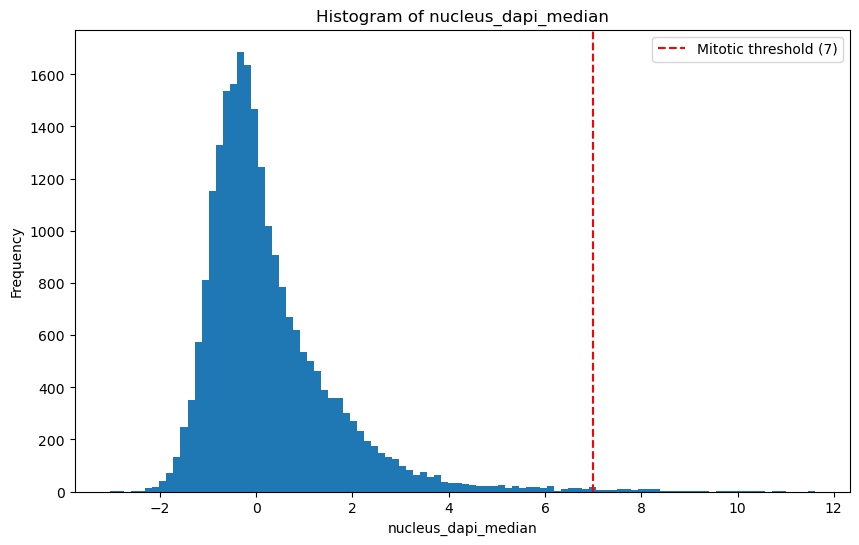

Number of mitotic cells: 109
Total cells: 23,022
Percent mitotic: 0.47%


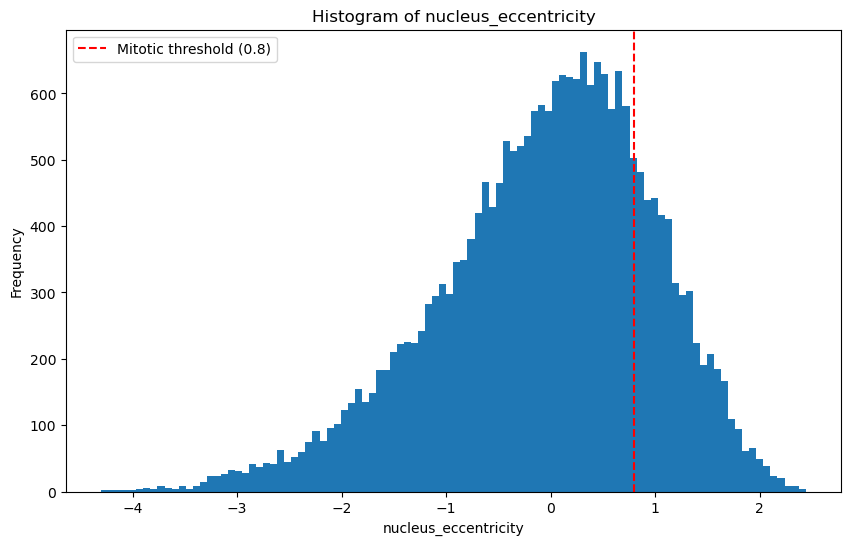

Number of mitotic cells: 4,731
Total cells: 23,022
Percent mitotic: 20.55%


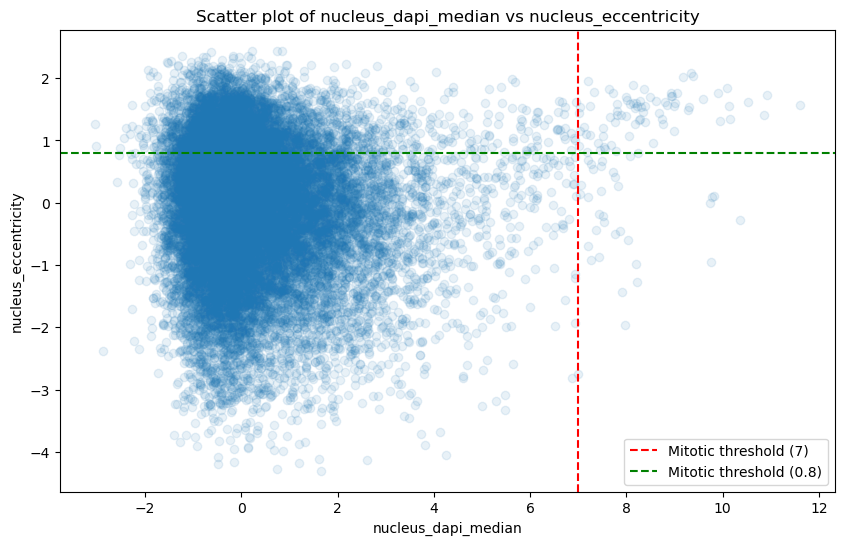

Number of mitotic cells: 77
Total cells: 23,022
Percent mitotic: 0.33%


In [11]:
percent_mitotic = plot_mitotic_distribution_hist(
    standardized_df,
    threshold_variable=MITOTIC_THRESHOLD_VARIABLE_X,
    threshold_value=MITOTIC_THRESHOLD_X,
)

percent_mitotic = plot_mitotic_distribution_hist(
    standardized_df,
    threshold_variable=MITOTIC_THRESHOLD_VARIABLE_Y,
    threshold_value=MITOTIC_THRESHOLD_Y,
)

plot_mitotic_distribution_scatter(
    standardized_df,
    threshold_variable_x=MITOTIC_THRESHOLD_VARIABLE_X,
    threshold_variable_y=MITOTIC_THRESHOLD_VARIABLE_Y,
    threshold_x=MITOTIC_THRESHOLD_X,
    threshold_y=MITOTIC_THRESHOLD_Y,
    alpha=0.1,
)

## SET PARAMETERS

### Final mitotic thresholding variable

- `MITOTIC_THRESHOLD_VARIABLE`: Column name used to identify mitotic cells (e.g., 'nucleus_dapi_int' for DAPI intensity)  
- `MITOTIC_THRESHOLD`: Numerical threshold to separate mitotic from interphase cells (examine intensity histogram to determine appropriate value)

In [12]:
# Final thresholding
MITOTIC_THRESHOLD_VARIABLE = "nucleus_dapi_median"
MITOTIC_THRESHOLD = 7

Subsetting 109 mitotic cells and 22913 interphase cells


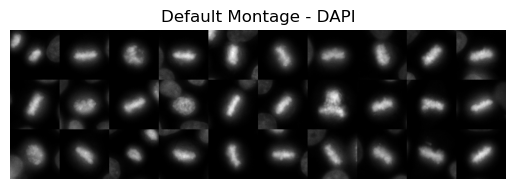

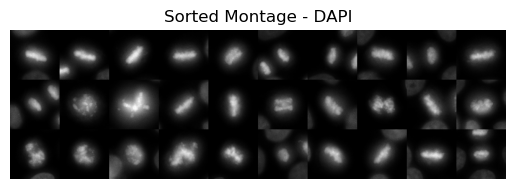

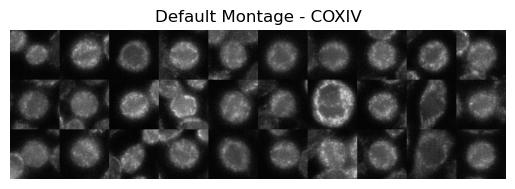

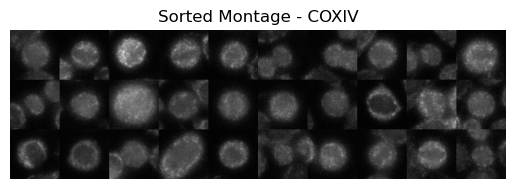

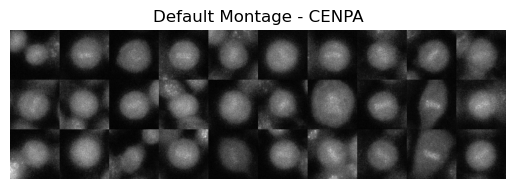

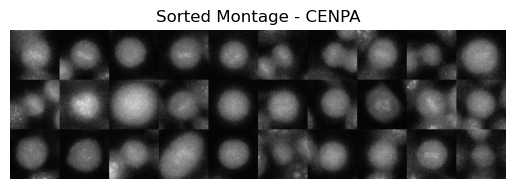

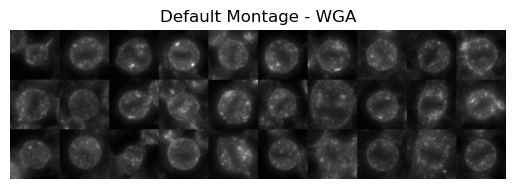

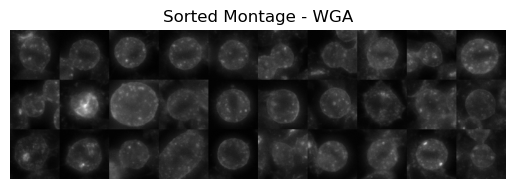

In [13]:
# Use final thresholding to split cells
conditions = {
    MITOTIC_THRESHOLD_VARIABLE: (MITOTIC_THRESHOLD, "greater"),
}
mitotic_df, interphase_df = split_mitotic_simple(standardized_df, conditions)
print(
    f"Subsetting {len(mitotic_df)} mitotic cells and {len(interphase_df)} interphase cells"
)

# TODO: Remove when done with testing on Denali data
# redirects actual paths to paths of Denali data
def update_file_path(row):
    original_path = row["image_path"]
    parts = original_path.split("/")[-1].split("__")[0].split("_")
    well, tile = parts[0][1:], parts[1][1:]
    new_path = f"/archive/cheeseman/OpticalPooledScreens/lab/barcheese01/screens/denali/input_ph_tif/20X_{well}_Tile-{tile}.phenotype.tif"
    return new_path
mitotic_df["image_path"] = mitotic_df.apply(update_file_path, axis=1)

# Get channels from config
CHANNELS=config["phenotype_process"]["channel_names"]

# Default montage
default_mitotic_cell_montages = create_mitotic_cell_montage(cell_data=mitotic_df, channels=CHANNELS)

# Sorted by median dapi intensity montage
sorted_mitotic_cell_montages = create_mitotic_cell_montage(
    cell_data=mitotic_df,
    channels=CHANNELS,
    selection_params={
        "method": "sorted",
        "sort_by": "nucleus_dapi_median",
        "ascending": True,
    },
)

# Show montages
for channel in CHANNELS:
    # Default montage
    default_mitotic_cell_montage = default_mitotic_cell_montages[channel]
    plt.title(f"Default Montage - {channel}")
    plt.imshow(default_mitotic_cell_montage, cmap="gray")
    plt.axis("off")  # Hide axis
    plt.show()

    # Sorted montage
    sorted_mitotic_cell_montage = sorted_mitotic_cell_montages[channel]
    plt.title(f"Sorted Montage - {channel}")
    plt.imshow(sorted_mitotic_cell_montage, cmap="gray")
    plt.axis("off")  # Hide axis
    plt.show()

In [14]:
# Re-standardize mitotic population
mitotic_standardized_df = grouped_standardization(
    mitotic_df,
    population_feature=POPULATION_FEATURE,
    control_prefix=CONTROL_PREFIX,
    group_columns=GROUP_COLUMNS,
    index_columns=INDEX_COLUMNS,
    cat_columns=CAT_COLUMNS,
    target_features=target_features,
    drop_features=True,
)

# Re-standardize interphase population
interphase_standardized_df = grouped_standardization(
    interphase_df,
    population_feature=POPULATION_FEATURE,
    control_prefix=CONTROL_PREFIX,
    group_columns=GROUP_COLUMNS,
    index_columns=INDEX_COLUMNS,
    cat_columns=CAT_COLUMNS,
    target_features=target_features,
    drop_features=True,
)

# Get sgrna summaries for mitotic 
mitotic_sgrna_df = collapse_to_sgrna(
    mitotic_standardized_df,
    method="median",
    target_features=target_features,
    index_features=[POPULATION_FEATURE, "sgRNA_0"],
    control_prefix=CONTROL_PREFIX,
)

# Get sgrna summaries for interphase 
interphase_sgrna_df = collapse_to_sgrna(
    interphase_standardized_df,
    method="median",
    target_features=target_features,
    index_features=[POPULATION_FEATURE, "sgRNA_0"],
    control_prefix=CONTROL_PREFIX,
)

# Get gene summaries for mitotic 
mitotic_gene_df = collapse_to_gene(
    mitotic_sgrna_df,
    target_features=target_features,
    index_features=[POPULATION_FEATURE],
)

# Get gene summaries for interphase 
interphase_gene_df = collapse_to_gene(
    interphase_sgrna_df,
    target_features=target_features,
    index_features=[POPULATION_FEATURE],
)

# Show summary of subset aggregation
summary = pd.DataFrame(
    {
        "Stage": [
            "Raw Data",
            "Mitotic Cells",
            "Interphase Cells",
            "Mitotic sgRNAs",
            "Interphase sgRNAs",
            "Mitotic Genes",
            "Interphase Genes",
        ],
        "Count": [
            len(clean_df),
            len(mitotic_df),
            len(interphase_df),
            len(mitotic_sgrna_df),
            len(interphase_sgrna_df),
            len(mitotic_gene_df),
            len(interphase_gene_df),
        ],
    }
)
print("\nAnalysis Summary of Data Subset:")
summary

Multiple control guides not found. Renaming to ensure uniqueness.
Multiple control guides not found. Renaming to ensure uniqueness.

Analysis Summary of Data Subset:


,Stage,Count
0,Raw Data,23022
1,Mitotic Cells,109
2,Interphase Cells,22913
3,Mitotic sgRNAs,106
4,Interphase sgRNAs,9950
5,Mitotic Genes,105
6,Interphase Genes,4781
